- - -
    Данный ноутбук является первой частью проекта. В нем решается задача кластеризации товаров на данных с 3х складов компании в Казахстане одновременно, чтобы построить модель кластеризации, которая подойдет для всех складов. Соответственно тут изучаются и описывабтся данные, формируются и отбираются признаки, формируется итоговый дата сет, а также происходит выбор модели кластеризации, а также создание на основе ее модели классификации данных, сериализация ее во внешний файл, как итог данного этапа.

**Зафиксируем глобальные переменные**

In [1]:
region = 'СУМ' #Выберем склад СУМ - суммарно по 3м складам (для обучения модели)

**Загрузка библиотек**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import re
from sklearn import manifold
from sklearn import model_selection
from sklearn import metrics

import plotly.graph_objs as go
import plotly.express as px

from sklearn import tree 

%matplotlib inline
plt.style.use('seaborn')

C:\Users\killr\AppData\Local\Temp\ipykernel_576\724232641.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


**Загрузка данных**

*Данные взяты, как выгрузки из программы 1С УТ11. У меня была возможность настроить форму этих вырузок через свой ИТ-отдел так, чтобы данные были максимально "чистые". Но я все равно проведу проверки этапа предобработки. Сейчас они выгружаются автоматически каждый день. Эти выгрузки представляют три таблицы: данные о продажах товаров по дням, остатках товаров по дням, а также данные с параметрами той или иной товарной позиции*

In [3]:
Sales = pd.read_excel('data\Загрузка продажи '+region+'.xlsx')
Stocks = pd.read_excel('data\Остатки загрузка '+region+'.xlsx')
Nomen = pd.read_excel('data\Загрузка справочник '+region+'.xlsx')

Посмотрим на таблицу Sales

In [4]:
Sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11746 entries, 0 to 11745
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Дата        11746 non-null  object 
 1   Артикул     11746 non-null  int64  
 2   Менеджер    11746 non-null  object 
 3   Клиент      11746 non-null  object 
 4   Продажа ШТ  11746 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 459.0+ KB


В данной таблице:
* **Дата** - это дата совершения продажи. Требует перевода в формат datetime
* **Артикул** - это уникальный номер товарной позиции, которая была продана. Формат int64 - подходящий
* **Менеджер** - это менеджер клиента, которому продан товар. Формат верный.
* **Клиент** - это уникальное название клиента. Формат верный.
* **Продажа ШТ** - это сколько базовых единиц товара продано.

Проверим на дубликаты (по логике дубликатов в дынных быть не должно)

In [5]:
if Sales.shape[0] == Sales.drop_duplicates().shape[0]:
    print('дубликатов нет')

дубликатов нет


Проверим на пропуски

In [6]:
Sales.isnull().sum()

Дата          0
Артикул       0
Менеджер      0
Клиент        0
Продажа ШТ    0
dtype: int64

*видим, что пропусков нет*

In [7]:
Sales = Sales.rename({'Дата':'ДАТА', 'Артикул':'АРТИКУЛ', 'Менеджер':'МЕНЕДЖЕР','Клиент':'КЛИЕНТ','Продажа ШТ':'ПРОДАЖА ШТ'}, axis=1)

Посмотрим на таблицу Stocks

In [8]:
Stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106139 entries, 0 to 106138
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Дата                        106139 non-null  object 
 1   Склад                       106139 non-null  object 
 2   Артикул                     106139 non-null  int64  
 3   Номенклатура                106139 non-null  object 
 4   Цена                        105339 non-null  float64
 5   Есть общие обороты за день  106139 non-null  object 
 6   Расход                      9634 non-null    float64
 7   Кон ост                     91607 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 6.5+ MB


В данной таблице:
* **Дата** - это дата на которую зафиксирован остаток. Требует перевода в формат datetime
* **Склад** - это склад остатка
* **Артикул** - это уникальный номер товарной позиции. Формат int64 - подходящий
* **Номенклатура** - это наименование товара в учетной системе, откуда взяты данные
* **Цена** - это условная учетная цена единицы товара в тенге
* **Есть общие обороты за день** - это техническое поле-артефакт, которое выгрузилось из учетной системы
* **Расход** - это сколько товара списано со склада за данную дату. Сюда входит не только продажа, но и перемещения, списания и т.д.
* **Кон ост** - это конечный остаток в базовых единицах на дату

Проверим на дубликаты (по логике дубликатов в дынных быть не должно)

In [9]:
if Stocks.shape[0] == Stocks.drop_duplicates().shape[0]:
    print('дубликатов нет')

дубликатов нет


Проверим на пропуски

In [10]:
Stocks.isnull().sum()

Дата                              0
Склад                             0
Артикул                           0
Номенклатура                      0
Цена                            800
Есть общие обороты за день        0
Расход                        96505
Кон ост                       14532
dtype: int64

* *Пропуски в цене - это артефакты из учетной системы. Данные товар не расценен на нужную дату.*
* *Пропуски в расходе - расхода не было он был нулевой*
* *Конечный остаток - конечный остаток на дату нулевой*
* *Просто заменим расход и конечный остаток нулями, а цену медианным значением.*

In [11]:
Stocks = Stocks.fillna({'Цена': Stocks['Цена'].median(), 'Расход': 0, 'Кон ост': 0})
Stocks = Stocks.rename({'Дата':'ДАТА', 'Артикул':'АРТИКУЛ', 'Цена':'ЦЕНА','Кон ост':'ОСТАТОК','Расход':'РАСХОД'}, axis=1)
Stocks = Stocks.drop(['Склад','Есть общие обороты за день','Номенклатура'], axis=1)

Посмотрим на таблицу Nomen

In [12]:
Nomen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2127 entries, 0 to 2126
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Артикул     2127 non-null   int64 
 1   Товар       2127 non-null   object
 2   Ед изм      2127 non-null   object
 3   Прямой      2127 non-null   object
 4   Поставщик   2127 non-null   object
 5   Активность  2124 non-null   object
 6   АГ          2121 non-null   object
 7   НГ          2126 non-null   object
dtypes: int64(1), object(7)
memory usage: 133.1+ KB


В данной таблице:
* **Артикул** - это уникальный номер товарной позиции. Формат int64 - подходящий
* **Товар** - это наименование товара в учетной системе, откуда взяты данные
* **Ед изм** - это единица измерения, как она зафиксирована в учетной системе
* **Прямой** - это показатель учетной систеиы, которые отличает товары приходящие с РЦ и напрямую от поставщика
* **Поставщик** - это наименование Поставщика данного товара
* **Активность** - это маркер в учетной системе, который показывает попадает ли данный товар в прайс
* **АГ** - Ассортиментная группа (параметр товара учетной системы)
* **НГ** - Номенклатурная группа (параметр товара учетной системы)

In [13]:
if Nomen.shape[0] == Nomen.drop_duplicates().shape[0]:
    print('дубликатов нет')

дубликатов нет


In [14]:
Nomen.isnull().sum()

Артикул       0
Товар         0
Ед изм        0
Прямой        0
Поставщик     0
Активность    3
АГ            6
НГ            1
dtype: int64

In [15]:
Nomen = Nomen.fillna({'Активность': Nomen['Активность'].mode()[0]})
Nomen = Nomen.rename({'Артикул':'АРТИКУЛ', 'Товар':'ТОВАР','Ед изм':'ЕД ИЗМ','Прямой':'ПРЯМОЙ', 
                      'Поставщик':'ПОСТАВЩИК','Активность':'АКТИВНОСТЬ' }, axis=1)

## РЕШЕНИЕ ПРОБЛЕМЫ КЛАСТЕРИЗАЦИИ ТОВАРОВ ПО ТИПАМ И ЗАПИСЬ МОДЕЛИ КЛАССИФИКАЦИИ НОВЫХ ДАННЫХ ПОД ЭТО РЕШЕНИЕ

**Что делаем дальше?**

У нас на самом деле еще нет данных. Мы будем кластеризовать именно сами товары. Соответвенно, мы должны получить таблицу товаров и составить правильные признаки товаров, которые помогут провести правильную кластеризацию.

Мы составим много разных признаков, которые характиризуют тот или иной товар. А потом проведем их отбор.

Есть еще один момент. В номенклатуре нет прямых дубликатов. Но есть товары, которые по сути одинаковые, но отличаются, например, только тем товар по прямой потсавке этот товар или нет. А также в номенклатуре есть дубликаты "ошибки". Например, где название отличается немного, например, стоит лишняя точка. Такие товары мы "склеим", как одинаковые, но оставим "ключи" в таблице, для будущей интерпретации пользователем.

**Избавимся от "дубликатов по сути" в номенклатуре**

Склеивать будем АРТИКУЛЫ с одинаковым названием, единицами измерения и поставщиками. Но сначала склеим названия, которые одинаковые за минусом каких-то знаков препинания или разницы в регистре.

In [16]:
Nomen['ТОВАР_КОРР'] = Nomen['ТОВАР'].apply( lambda x: re.sub(r'[\W]','', x).lower() )

Теперь сгруппируем товары с разными артикулами, но одинаковым скорректированным названием, единицей измерения, поставщиком. Выберем из них один основной артикул. Запомним неосновные артикулы, как список дубликатов, заменим дублирующие артикулы на основной во таблицах продаж и остатков.

In [17]:
#получим таблицу где дублирующие артикулы сгруппированы в список в поле АРТИКУЛ
multi_df = Nomen.groupby(['ТОВАР_КОРР','ЕД ИЗМ','ПОСТАВЩИК'])['АРТИКУЛ'].unique().reset_index()
multi_df['len'] = multi_df['АРТИКУЛ'].apply(len)

#Получим список из массивов дублирующих артикулов
art_groups = list(multi_df[multi_df['len']>1]['АРТИКУЛ'].values)

#Пройдем в цикле по всем массивам дублирующихся артикулов и создадим словарь,
# который используем для замены дубликатов на какой-то головной артикул
arts_to_delete = list() #список артикулов к замене
d_art_head = dict() #словарь - что на что заменять
for item in art_groups:
    for art in item:
        l = list(item.copy())
        l.pop(0)
        d_art_head[art] = [item[0], l]
        arts_to_delete.extend(l)

arts_to_delete = list(set(arts_to_delete)) #очистим повторы в списке к удалению

#Проведем замену артикулов на головной и запомним дубликаты
Sales['АРТИКУЛ'] = Sales['АРТИКУЛ'].apply(lambda x: x if x not in list(d_art_head.keys()) else d_art_head[x][0])
Stocks['АРТИКУЛ'] = Stocks['АРТИКУЛ'].apply(lambda x: x if x not in list(d_art_head.keys()) else d_art_head[x][0])
Nomen['ДУБЛИКАТЫ'] = Nomen['АРТИКУЛ'].apply(lambda x: '' if x not in list(d_art_head.keys()) else d_art_head[x][1])

Nomen.index = Nomen['АРТИКУЛ']
Nomen = Nomen.drop(arts_to_delete,axis=0).drop('АРТИКУЛ',axis=1)
Nomen = Nomen.reset_index()
Nomen = Nomen.drop('ТОВАР_КОРР', axis=1)


**Сделаем преобразования даты и вычислим параметр медианных недельных продаж**

In [18]:
#Выведем условный номер "скользящей недели". Данные на 12 недель. Получаем 12 различных номеров недель, например от среды до вторника.
Sales['ДАТА'] = pd.to_datetime(Sales['ДАТА'], format='%d.%m.%Y')
Sales['ДАТА_число'] = Sales['ДАТА'].dt.dayofyear
min_date = Sales['ДАТА_число'].min()
Sales['ДАТА_число'] = Sales['ДАТА_число'] - min_date
Sales['НЕДЕЛЯ'] = Sales['ДАТА_число'] // 7

In [19]:
#Вычислим понедельные продажи. Признаками будут артикулы. После этого вычислим медианные понедельные продажи в таблице week_sales
week_sales = pd.pivot_table(data = Sales, columns='АРТИКУЛ',index='НЕДЕЛЯ', values='ПРОДАЖА ШТ', aggfunc='sum')
week_sales = week_sales.fillna(0)
week_sales = week_sales.median()

In [20]:
Stocks['ДАТА'] = Stocks['ДАТА'].apply(lambda x: x[:-8]) #это чтобы отрезать время 00:00:00 в каждой дате
Stocks['ДАТА'] = pd.to_datetime(Stocks['ДАТА'] , format='%d.%m.%Y')

*Далее мы создадим таблицу по артикулам на основании таблицы Nomen со списком номенклатуры и создадим признаки связанные и с продажами, и с остатками, и с числом клиентов. По сути на этом этапе продолжается предобработка данных и формируются признаки для отбора*

In [21]:
#Отрежем лишние буквы, чтобы визуализация потом была более наглядной
Nomen['ПОСТАВЩИК'] = Nomen['ПОСТАВЩИК'].apply(lambda x: x[:15])
Nomen['АГ'] = Nomen['АГ'].apply(lambda x: str(x)[:20])

**Признак числа клиентов**

In [22]:
table = Sales.groupby('АРТИКУЛ')['КЛИЕНТ'].nunique()

Client_count = list(Nomen['АРТИКУЛ'].unique())
Client_count = pd.DataFrame(Client_count, columns=['АРТИКУЛ'])
Client_count['Count'] = Client_count['АРТИКУЛ'].apply(lambda x: 0 if x not in list(table.index) else table[x])
Client_count.index = Client_count['АРТИКУЛ']
Client_count = Client_count.drop('АРТИКУЛ', axis=1)

#Таблица piv_nom будет основной таблицей. Начнем ее формировать
piv_nom = Nomen.copy()
#Запишем число КЛИЕНТОВ в итоговую таблицу
piv_nom['КЛИЕНТОВ'] = piv_nom['АРТИКУЛ'].apply(lambda x: Client_count.loc[x])
#Запишем медианные продажи в неделю в итоговую таблицу
piv_nom['week_sales_median'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if x not in list(week_sales.index) else week_sales.loc[x])

**Признак Доли самого крупного клиента в продажах**

In [23]:
#Вычислим продажи в штуках поклиентно по артикулу и отсортируем по убыванию
table = Sales.groupby(['АРТИКУЛ', 'КЛИЕНТ'])['ПРОДАЖА ШТ'].sum().reset_index().sort_values(by=['АРТИКУЛ','ПРОДАЖА ШТ'], ascending=False)
#Вычислим продажи в штуках суммарно по артикулу, а потом сцепим слева с продажами по максимальному клиенту
table2 = Sales.groupby(['АРТИКУЛ'])['ПРОДАЖА ШТ'].sum().sort_values(ascending=False).reset_index()
table = pd.merge(left=table, right=table2, on='АРТИКУЛ', how='left')
table['ДОЛЯ'] = table['ПРОДАЖА ШТ_x'] / table['ПРОДАЖА ШТ_y']
table = table.groupby('АРТИКУЛ')['ДОЛЯ'].max()
piv_nom['ДОЛЯ МАКС КЛИЕНТА'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if x not in list(table.index) else table.loc[x])
piv_nom.head(2)

АРТИКУЛ                                              ТОВАР ЕД ИЗМ ПРЯМОЙ  \
0  1103014  Пакет фасовочный 240х370 мм 8 мкм, "МИСТЕРИЯ" ...    рул    Нет   
1  1187021  Набор одноразовой посуды "На Троих" [3 стак. 1...   упак    Нет   

         ПОСТАВЩИК АКТИВНОСТЬ                    АГ  \
0    ВАШ ПАКЕТ ООО         Да     Пакеты фасовочные   
1  ПК ДИАПАЗОН ООО         Да  Наборы одноразовой п   

                                         НГ ДУБЛИКАТЫ  КЛИЕНТОВ  \
0  Пакеты фасовочные ПНД в рулонах 8-10 мкм                   6   
1   Наборы одноразовой посуды на 3-5 персон                   1   

   week_sales_median  ДОЛЯ МАКС КЛИЕНТА  
0                0.5                0.5  
1                0.0                1.0

**Вычисление средней цены за период**

*Это вычсление нужно т.к. цена из исходных таблиц могла меняться на разные даты*

In [24]:
table = Stocks.groupby('АРТИКУЛ')['ЦЕНА'].median()
piv_nom['ЦЕНА'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if x not in list(table.index) else table.loc[x])

**Вычисление статистических признаков стока и продаж**

Вычислим статистические параметры остатков

In [25]:
table = pd.pivot_table(Stocks,values='ОСТАТОК',aggfunc='sum',columns='АРТИКУЛ', index='ДАТА').sort_index()
#Заменим нули на значения NaN, чтобы вычислить по каждому артикулу долю дней в периоде без остатка на складе
table = table.replace(to_replace=0., value=np.nan)
stock_nulls = table.isnull().mean() 
table = table.fillna(0)

*С этого момента таблица table будет таблицей остатка по дням по каждому артикулу. Оставим этот комментарий, т.к. абстрактное название нарушает принцип правильных наименований объетов при написании кода*

In [26]:
piv_nom = pd.merge(left=piv_nom, right=table.describe().T.reset_index()[['АРТИКУЛ','mean','std','max','50%']], on='АРТИКУЛ', how='left')
piv_nom = piv_nom.rename({'mean':'stocks_mean','std':'stocks_std', 'max':'stocks_max','50%':'stocks_median'}, axis=1)

In [27]:
#Вычислим показатель текущего остатка. Он будет нужен для формирования рекомендаций по заказу
curr_stock = table.iloc[-1:].T
piv_nom['curr_stock'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if x not in list(curr_stock.index) else curr_stock.loc[x].values[0]) 

Вычислим статистические параметры продаж

In [28]:
table2 = pd.pivot_table(Sales,values='ПРОДАЖА ШТ',aggfunc='sum',columns='АРТИКУЛ', index='ДАТА').sort_index()
sales_nulls = table2.isnull().mean()
table2 = table2.fillna(0)

*С этого момента таблица table2 будет таблицей продаж по дням по каждому артикулу. т.к. абстрактное название нарушает принцип правильных наименований объетов при написании кода*

In [29]:
piv_nom = pd.merge(left=piv_nom, right=table2.describe().T.reset_index()[['АРТИКУЛ','mean','std','max','50%']], on='АРТИКУЛ', how='left')
piv_nom = piv_nom.rename({'mean':'sales_mean','std':'sales_std', 'max':'sales_max','50%':'sales_median'}, axis=1)
piv_nom = piv_nom.fillna(0) 

- - -
    ПРИМЕЧАНИЕ
    Пояснение идеи. Или почему я решил попробовать использовать кластеризацию. Стандартный baseline предполагает, что рекомендация для закупщика по заказу считается просто по среднедневным продажам. Ниже я выберу несколько графиков остатков/продаж по определенному артикулу, для которых очевидно, что такой baseline не работает. Разберем это на 3х примерах.

    Еще один момент по графикам в обучающих данных. На некоторых графиках остатки обнуляются на один день, а на следующий снова возвращаются. Это связано с тем, что данные у нас с разных складов, а некоторые из складов работали в выходные. Когда как данные у нас за рабочие дни каждого склада. По идее, их можно заполнить, но как ни странно, у нас нет признаков, которые принципиально изменяются, от обнуления остатков в паре мест. Поэтому оставим, как есть.

Пример 1

средние продажи:  0.12


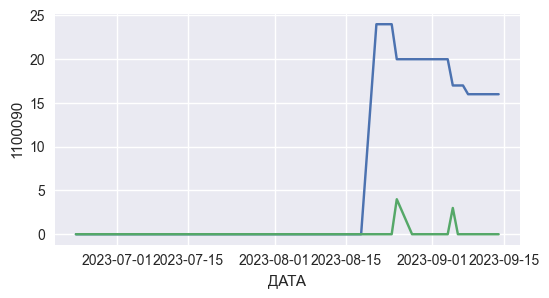

In [30]:
art = 1100090
fig = plt.figure(figsize=[6,3])
sns.lineplot(table[art].T)
sns.lineplot(table2[art].T)
print('средние продажи: ', table2[art].T.mean().round(2))

Среднедневные продажи = 0.12. Но стандартная методология считает за полный период продаж. Однако, товар только появился. Очевидно, что при планировании заказов, планировать нельзя по всему периоду, а надо, например, учитывать продажи за последнюю треть периода только. Или каким-то другим образом для "условно" новинок считать необходимый запас с какой-то коррекцией. baseline подход этого не позволяет.

Пример 2

средние продажи:  0.6


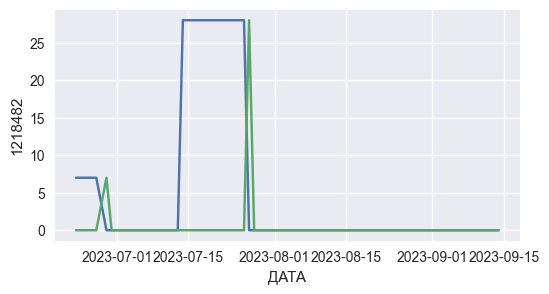

In [31]:
art = 1218482
fig = plt.figure(figsize=[6,3])
sns.lineplot(table[art].T)
sns.lineplot(table2[art].T)
print('средние продажи: ', table2[art].T.mean().round(2))

Товар с двумя продажами. Если мы хотим посчитать уровень дефицита, то по этому товару он явно какой-то не такой, как по обычному товару, который постоянно и стабильно продается.

Пример 3

средние продажи:  6.38


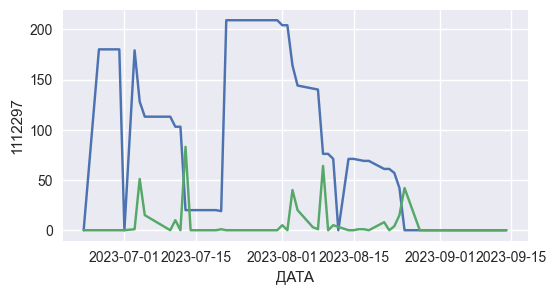

In [32]:
art = 1112297
fig = plt.figure(figsize=[6,3])
sns.lineplot(table[art].T)
sns.lineplot(table2[art].T)
print('средние продажи: ', table2[art].T.mean().round(2))

Вот на этом графике очень много продаж-выбросов. Очевидно, что поддерживать на складе нужно не менее 50ти единиц, иначе мы типичный заказ не выполним. Но 50 единиц по средним продажам запас почти на 8 рабочих дней. Считай полторы недели. Это по baseline подходу. Очевидно, что запас на полторы недели - считается много при челевой оборачиваемости около 20-25 календарных дней. Но по факту это мало для товара, которые ведет себя, как на данном графике. baseline не работает

- - -
    На самом деле, если будем даже просто различать эти три варианта поведения товара, то мы уже решили задачу лучше, чем baseline

**Добавим признаки % дней без продаж и без остатков**

In [33]:
piv_nom['sales_nulls'] = piv_nom['АРТИКУЛ'].apply(lambda x: 1 if x not in list(sales_nulls.index) else sales_nulls[x])
piv_nom['stock_nulls'] = piv_nom['АРТИКУЛ'].apply(lambda x: 1 if x not in list(stock_nulls.index) else stock_nulls[x])

**Добавим признаки симметрии остатков и продаж**

Рассчитаем его как ксинус вектора последовательных продаж во времени с вектором линейного роста от минимума к максимуму.
В целом, это показатель того растут ли продажи во времени или падают. Чем ближе к 1 - тем скорее растут, чем ближе к -1 - тем скорее падают. чем ближе к нулю - тем стабильнее продажи/остатки за период.

In [34]:
def calc_sym_coef(art, table):
    min_val = table[art].min()
    max_val = table[art].max()
    v = np.linspace(min_val,max_val,table.shape[0])
    w = table[art].values
    v = v - v.mean()
    v = v / np.linalg.norm(v)
    w = w - w.mean()
    if np.linalg.norm(w)<0.0001:
        return 0
    w = w /np.linalg.norm(w)
    return v@w

piv_nom['stock_sym'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if x not in list(table.columns) else calc_sym_coef(x,table))
piv_nom['sales_sym'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if x not in list(table2.columns) else calc_sym_coef(x,table2))

**Создадим признаки в деньгах**

In [35]:
stat_features_units = ['stocks_mean','stocks_std','stocks_max','stocks_median',
                    'sales_mean', 'sales_std', 'sales_max','sales_median','curr_stock','week_sales_median']

for feature in stat_features_units:
    piv_nom[feature+'_$'] = piv_nom[feature] * piv_nom['ЦЕНА']

**Посмотрим на распределения созданных признаков и решим, что их этого стоит логарифмировать**

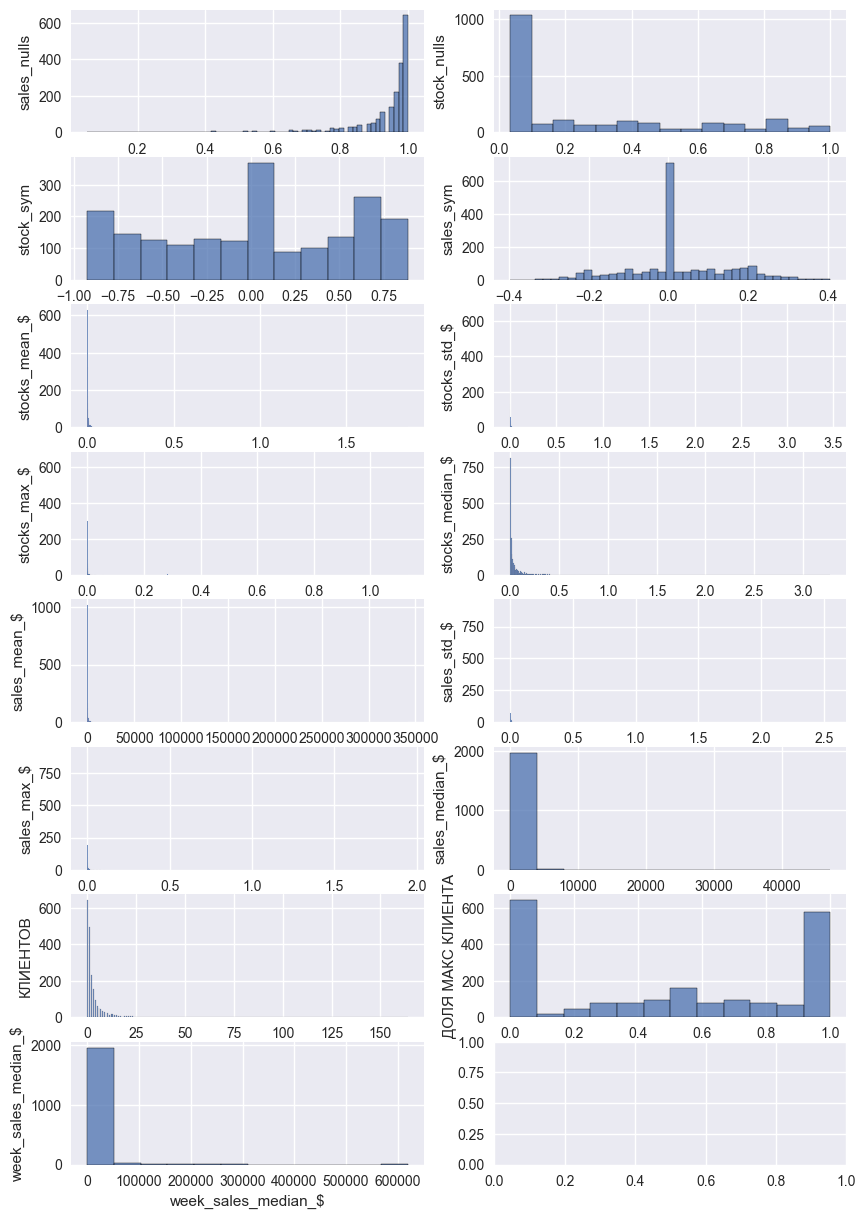

In [36]:
features = ['sales_nulls', 'stock_nulls', 'stock_sym', 'sales_sym',
       'stocks_mean_$', 'stocks_std_$', 'stocks_max_$', 'stocks_median_$',
       'sales_mean_$', 'sales_std_$', 'sales_max_$', 'sales_median_$','КЛИЕНТОВ', 'ДОЛЯ МАКС КЛИЕНТА','week_sales_median_$']

fig, axes = plt.subplots(len(features)//2+1,2, figsize = [10,15])
for i,feature in enumerate(features):
    sns.histplot(piv_nom[feature], ax= axes[i//2][i%2])
    axes[i//2][i%2].set_ylabel(feature)


**Создадим логарифмированные признаки, где видим распределения похожие на лог нормальные**

In [37]:
features_to_log = ['stocks_mean_$', 'stocks_std_$', 'stocks_max_$', 'stocks_median_$',
       'sales_mean_$', 'sales_std_$', 'sales_max_$', 'sales_median_$','КЛИЕНТОВ','week_sales_median_$']

for feature in features_to_log:
    piv_nom[feature+'_log'] = piv_nom[feature].apply(lambda x: 0 if (x+1)<=0 else np.log(x+1))

**Посмотрим, как выглядят распределения теперь**

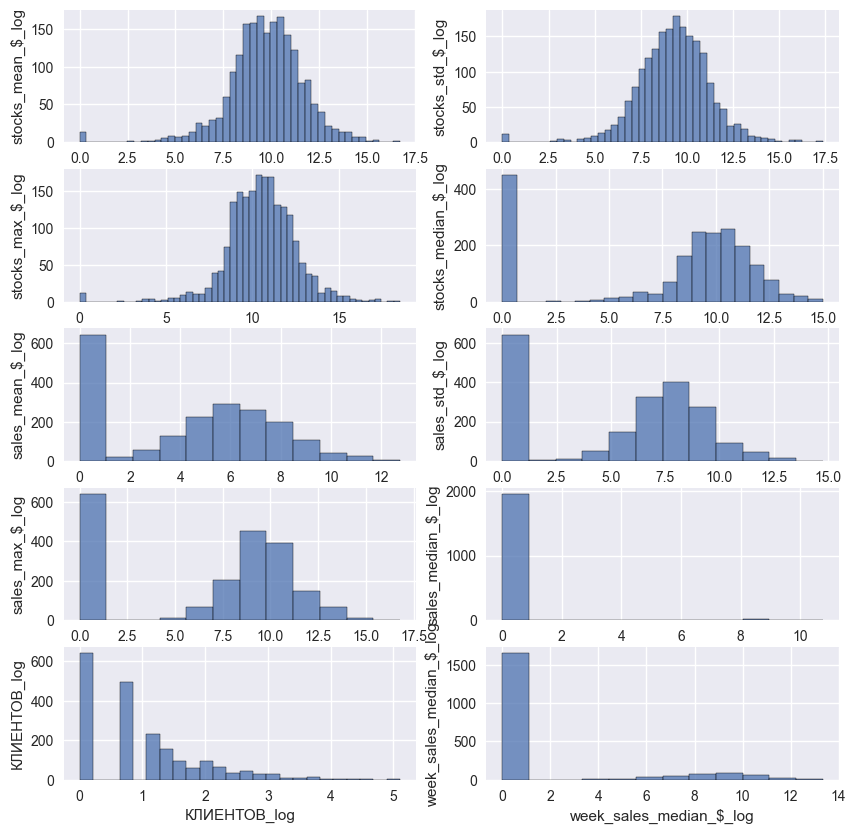

In [38]:
features = ['stocks_mean_$_log', 'stocks_std_$_log', 'stocks_max_$_log',
       'stocks_median_$_log', 'sales_mean_$_log', 'sales_std_$_log',
       'sales_max_$_log', 'sales_median_$_log', 'КЛИЕНТОВ_log','week_sales_median_$_log']

fig, axes = plt.subplots(len(features)//2,2, figsize = [10,10])
for i,feature in enumerate(features):
    sns.histplot(piv_nom[feature], ax= axes[i//2][i%2])
    axes[i//2][i%2].set_ylabel(feature)
    

**Отбор признаков для кластеризации**

Посмотрим на матрицу корреляций. У нас задача кластеризации, целевого признака нет. Поэтому будем убирать признаки мультиколлениарность.

Text(0.5, 1.0, 'Полная матрица корреляций признаков')

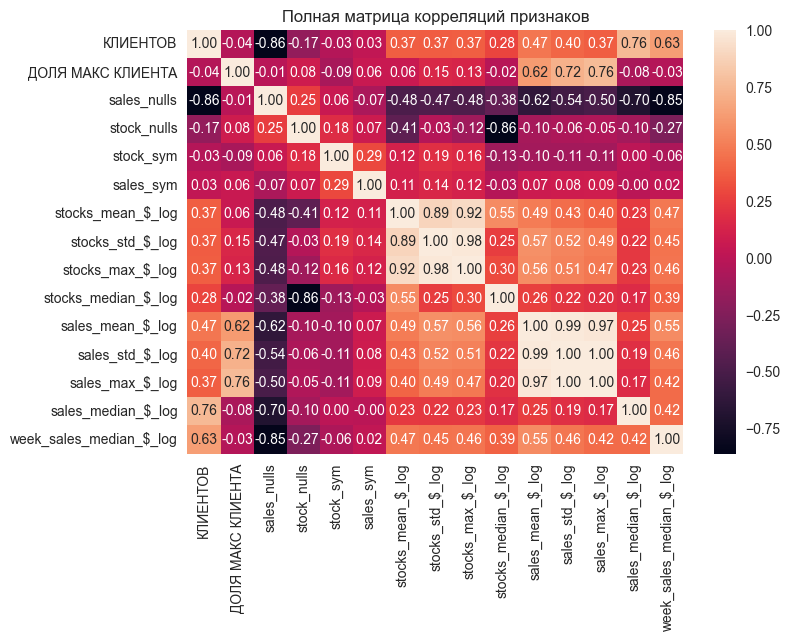

In [39]:
features = ['КЛИЕНТОВ', 'ДОЛЯ МАКС КЛИЕНТА',
       'sales_nulls', 'stock_nulls', 'stock_sym', 'sales_sym', 'stocks_mean_$_log', 'stocks_std_$_log',
       'stocks_max_$_log', 'stocks_median_$_log', 'sales_mean_$_log',
       'sales_std_$_log', 'sales_max_$_log', 'sales_median_$_log',
       'week_sales_median_$_log']

clust_data = piv_nom[features]

fig = sns.heatmap(clust_data.corr(), annot=True, fmt='.2f')
fig.set_title('Полная матрица корреляций признаков')


Ниже отобранные мной признаки и их матрица корреляций. Видим, что набор признаков получился такой, что даже близко нет мультиколлениарности. Набор выглядит очень сбалансированным: самая большая корреляция по мудулю 0.55. Это значит, что наш набор признаков характеризует очень разные особенности в поведении товаров.

Text(0.5, 1.0, 'Матрица корреляций отобранных признаков')

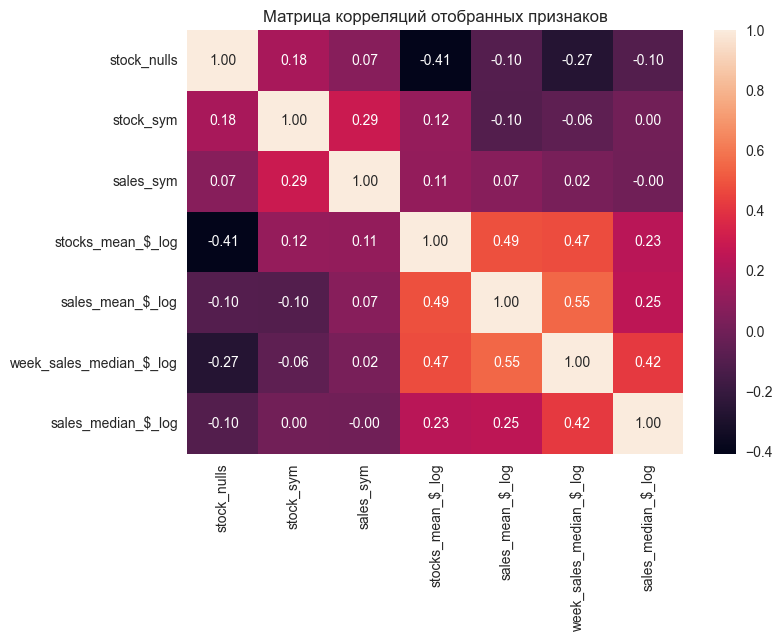

In [40]:
features = [ 'stock_nulls', 'stock_sym', 'sales_sym',
       'stocks_mean_$_log', 'sales_mean_$_log','week_sales_median_$_log','sales_median_$_log'] 

clust_data = piv_nom[features]

fig = sns.heatmap(clust_data.corr(), annot=True, fmt='.2f')
fig.set_title('Матрица корреляций отобранных признаков')

Нормализуем признаки для кластеризации

In [41]:
scaler = MinMaxScaler()
clust_data = scaler.fit_transform(clust_data)

**Выбор итогового метода кластеризации**

Напишем функцию для визуализации кластеров

In [42]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()

Сравнивать результат мы будем по коэффиценту силуаэта. Начнем с агломеративной кластеризации.

In [43]:
from sklearn.cluster import AgglomerativeClustering

params = list()
for i in range(3,20):
    agc = AgglomerativeClustering(n_clusters=i)
    clusters = agc.fit_predict(clust_data)
    params.append([i,silhouette_score(clust_data,clusters)])
    
params = pd.DataFrame(params, columns=['K','silhouette'])
params.sort_values('silhouette', ascending=False).iloc[:5]

K  silhouette
1   4    0.342487
5   8    0.342046
8  11    0.340602
7  10    0.338410
6   9    0.336107

Text(0.5, 0, 'Число кластеров')

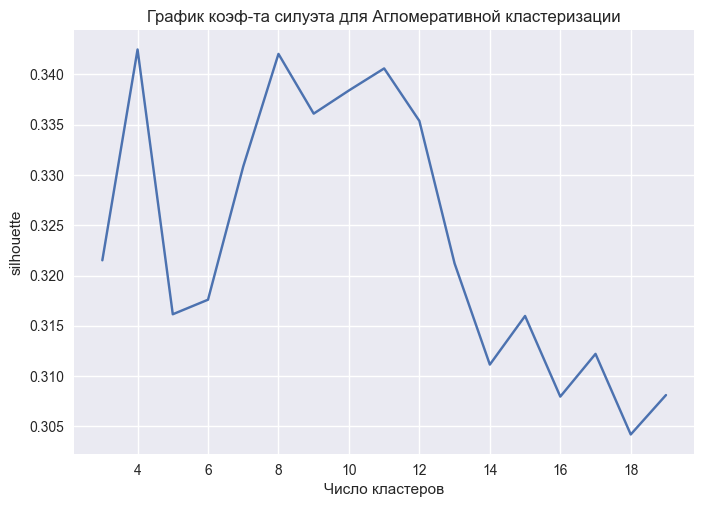

In [44]:
fig = sns.lineplot(data=params, x='K', y='silhouette')
fig.set_title('График коэф-та силуэта для Агломеративной кластеризации')
fig.set_xlabel('Число кластеров')

Обучим модель по оптимальному числу кластеров. Выберем 8, а не 4, хотя на 4х кластерах коэфицент силуэта чуть выше т.к. это больше соответсвует исходной задаче. Нам нужно более подробное разделение. Во-вторых, с учетом следующих моделей, видно что оптимельно разделение как раз на 8-10 кластеров. В том числе для этого и сравниваем разные варианты имоделирования.

In [45]:
agc = AgglomerativeClustering(n_clusters=8)
clusters = agc.fit_predict(clust_data)
piv_nom['cluster'] = clusters

Для каждого разделения по кластерам будем выводить в данном ноутбуке 3 варианта визуализации, для того, чтобы понять, что из себя кластеры представляют:
* Тепловая карта средних значений признаков по кластерам
* Диаграмма типа cluster_profile, на которой видно наглядно значимость признаков в разных кластерах
* Выведемполную информацию по графикам в каждом кластере последовательно. Просто, чтобы проще было кластеры назвать и внешне посмотреть какой вариант кластеризации оптимален с точки зрения исходной задачи.

Text(0.5, 1.0, 'Тепловая карта центроидов признаков по кластерам')

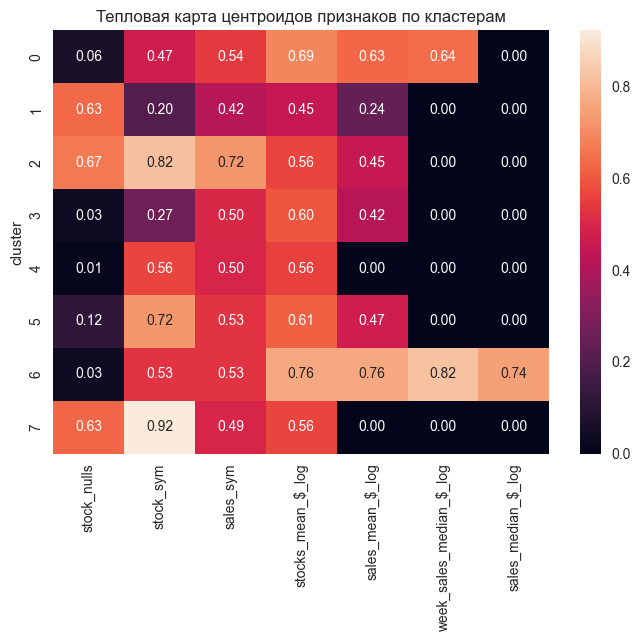

In [46]:
piv_nom_1 = piv_nom[ ['stock_nulls', 'stock_sym', 'sales_sym',
       'stocks_mean_$_log', 'sales_mean_$_log','week_sales_median_$_log','sales_median_$_log'] ]

scaler = MinMaxScaler()
piv_nom_1 = scaler.fit_transform(piv_nom_1)
piv_nom_1 = pd.DataFrame(piv_nom_1, columns=['stock_nulls', 'stock_sym', 'sales_sym',
       'stocks_mean_$_log', 'sales_mean_$_log','week_sales_median_$_log','sales_median_$_log'] )
piv_nom_1['cluster'] = clusters

cluster_definition = piv_nom_1.groupby('cluster').mean()
fig = sns.heatmap(cluster_definition, annot=True, fmt='.2f')
fig.set_title('Тепловая карта центроидов признаков по кластерам')

In [47]:
plot_cluster_profile(cluster_definition,8)

In [48]:
#for i in range(8):
#
#    cluster = list(piv_nom[piv_nom['cluster']==i]['АРТИКУЛ'])
#    #cluster = list(piv_nom[piv_nom['sales_median_$_log'] > 0]['АРТИКУЛ'])
#
#    fig, axes = plt.subplots(len(cluster)//6+2,6, figsize = [20,len(cluster)//6*2+3])
#    for i,art in enumerate(cluster):
#        if art in list(table.columns):
#            sns.lineplot(table[art].T, ax=axes[i//6][i%6])
#        if art in list(table2.columns):    
#            sns.lineplot(table2[art].T, ax=axes[i//6][i%6])
#        axes[i//6][i%6].set_xlabel(' ')
#        axes[i//6][i%6].set_ylabel(' ')
#        axes[i//6][i%6].set_title(art)
#     
#plt.tight_layout()

Посмотрим на кластеризацию по методу K-Means.

In [49]:
from sklearn.cluster import KMeans

params = list()
for i in range(3,20):
    agc = KMeans(n_clusters=i, random_state=100)
    clusters = agc.fit_predict(clust_data)
    params.append([i,silhouette_score(clust_data,clusters)])
    
params = pd.DataFrame(params, columns=['K','silhouette'])
params.sort_values('silhouette', ascending=False).iloc[:5]

c:\Users\killr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\killr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\killr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\killr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



K  silhouette
7  10    0.377602
6   9    0.371876
5   8    0.371474
9  12    0.368950
8  11    0.368517

Text(0.5, 0, 'Число кластеров')

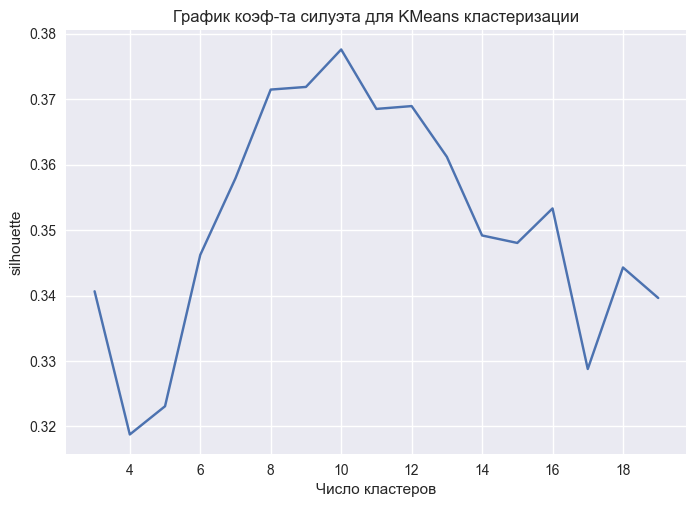

In [50]:
fig = sns.lineplot(data=params, x='K', y='silhouette')
fig.set_title('График коэф-та силуэта для KMeans кластеризации')
fig.set_xlabel('Число кластеров')

In [51]:
agc = KMeans(n_clusters=10, random_state=100)
clusters = agc.fit_predict(clust_data)
piv_nom['cluster'] = clusters

c:\Users\killr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Text(0.5, 1.0, 'Тепловая карта центроидов признаков по кластерам')

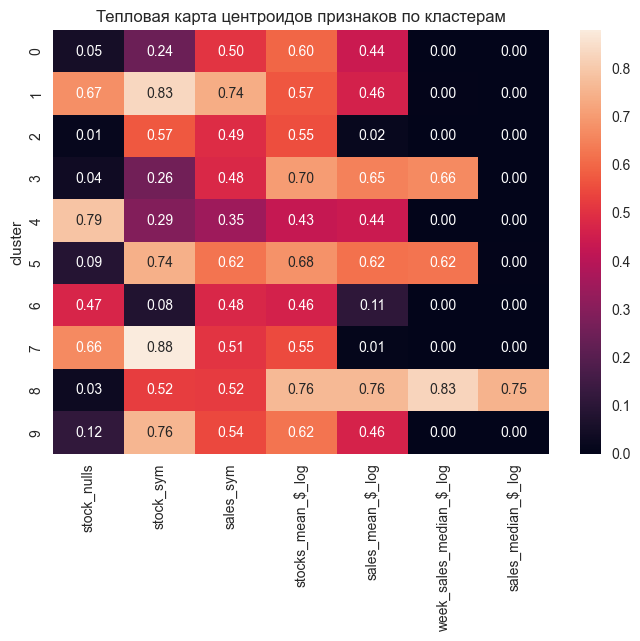

In [52]:
piv_nom_1 = piv_nom[ ['stock_nulls', 'stock_sym', 'sales_sym',
       'stocks_mean_$_log', 'sales_mean_$_log','week_sales_median_$_log','sales_median_$_log'] ]

scaler = MinMaxScaler()
piv_nom_1 = scaler.fit_transform(piv_nom_1)
piv_nom_1 = pd.DataFrame(piv_nom_1, columns=['stock_nulls', 'stock_sym', 'sales_sym',
       'stocks_mean_$_log', 'sales_mean_$_log','week_sales_median_$_log','sales_median_$_log'] )
piv_nom_1['cluster'] = clusters

cluster_definition = piv_nom_1.groupby('cluster').mean()
fig = sns.heatmap(cluster_definition, annot=True, fmt='.2f')
fig.set_title('Тепловая карта центроидов признаков по кластерам')

In [53]:
plot_cluster_profile(cluster_definition,10)

In [54]:
#for i in range(10):
#
#    cluster = list(piv_nom[piv_nom['cluster']==i]['АРТИКУЛ'])
#    #cluster = list(piv_nom[piv_nom['sales_median_$_log'] > 0]['АРТИКУЛ'])
#
#    fig, axes = plt.subplots(len(cluster)//6+2,6, figsize = [20,len(cluster)//6*2+3])
#    for i,art in enumerate(cluster):
#        if art in list(table.columns):
#            sns.lineplot(table[art].T, ax=axes[i//6][i%6])
#        if art in list(table2.columns):    
#            sns.lineplot(table2[art].T, ax=axes[i//6][i%6])
#        axes[i//6][i%6].set_xlabel(' ')
#        axes[i//6][i%6].set_ylabel(' ')
#        axes[i//6][i%6].set_title(art)
     
#plt.tight_layout()

Теперь попробуем сначала снизить размерность по алгоритму t-SNE, а потому уже применять кластеризацию

Text(0.5, 1.0, 'Визуализация распределения признаков в сниденной размероности до 2х')

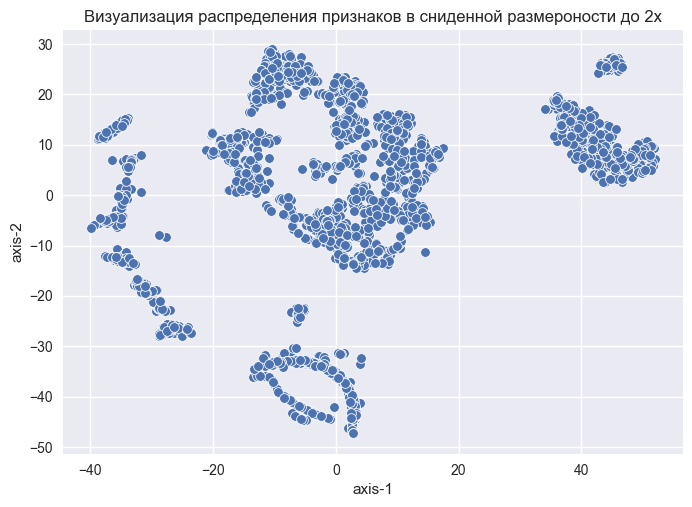

In [55]:

tSNE = manifold.TSNE(n_components=2, perplexity=50, random_state=100)
clust_data_trasformed = tSNE.fit_transform(clust_data)
clust_data_trasformed = pd.DataFrame(clust_data_trasformed, columns=['axis-1','axis-2'])


fig = sns.scatterplot(data=clust_data_trasformed, x='axis-1', y='axis-2')
fig.set_title('Визуализация распределения признаков в сниденной размероности до 2х')

c:\Users\killr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\killr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\killr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\killr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



0.57242805


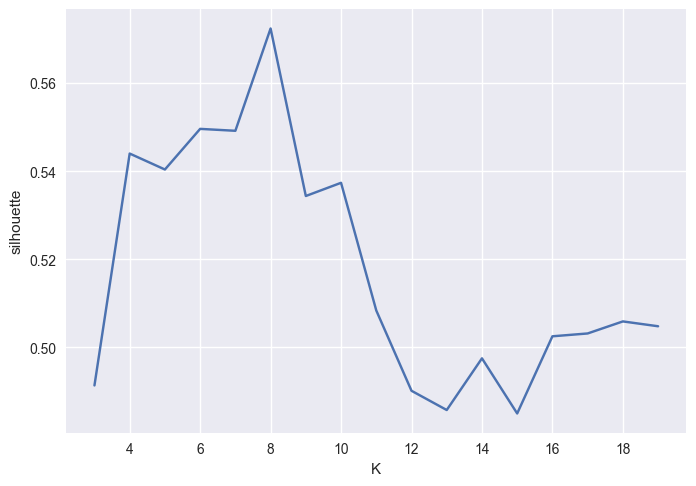

In [56]:
silhouette = []
for k in range(3,20):
    kmeans = KMeans(random_state=100, n_clusters=k)
    kmeans.fit(clust_data_trasformed)
    silhouette.append([k,silhouette_score(clust_data_trasformed, kmeans.labels_)])
    
silhouette = pd.DataFrame(silhouette, columns=['K','silhouette'])   
fig = sns.lineplot(silhouette, x='K', y='silhouette')
print(silhouette['silhouette'].max())

In [57]:
best_model = KMeans(random_state=100, n_clusters=8)
best_model.fit(clust_data_trasformed)
labels = best_model.labels_
pd.Series(best_model.labels_).value_counts()

c:\Users\killr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



2    338
5    337
7    307
0    266
6    221
4    189
3    179
1    162
dtype: int64

Text(0.5, 1.0, 'Визуализация кластеров в пространстве сниженной размерности')

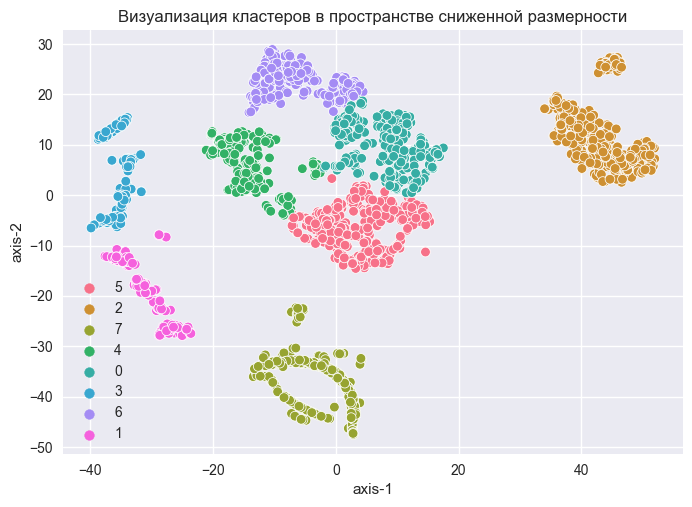

In [58]:
fig = sns.scatterplot(data=clust_data_trasformed, x='axis-1', y='axis-2', hue=best_model.labels_.astype('str'))
fig.set_title('Визуализация кластеров в пространстве сниженной размерности')

In [59]:
piv_nom['cluster'] = labels

In [60]:
#for i in range(8):
#
#    cluster = list(piv_nom[piv_nom['cluster']==i]['АРТИКУЛ'])
#    #cluster = list(piv_nom[piv_nom['sales_median_$_log'] > 0]['АРТИКУЛ'])
#
#    fig, axes = plt.subplots(len(cluster)//6+2,6, figsize = [20,len(cluster)//6*2+3])
#    for i,art in enumerate(cluster):
#        if art in list(table.columns):
#            sns.lineplot(table[art].T, ax=axes[i//6][i%6])
#        if art in list(table2.columns):    
#            sns.lineplot(table2[art].T, ax=axes[i//6][i%6])
#        axes[i//6][i%6].set_xlabel(' ')
#        axes[i//6][i%6].set_ylabel(' ')
#        axes[i//6][i%6].set_title(art)
     
#plt.tight_layout()

Text(0.5, 1.0, 'Тепловая карта центроидов кластров')

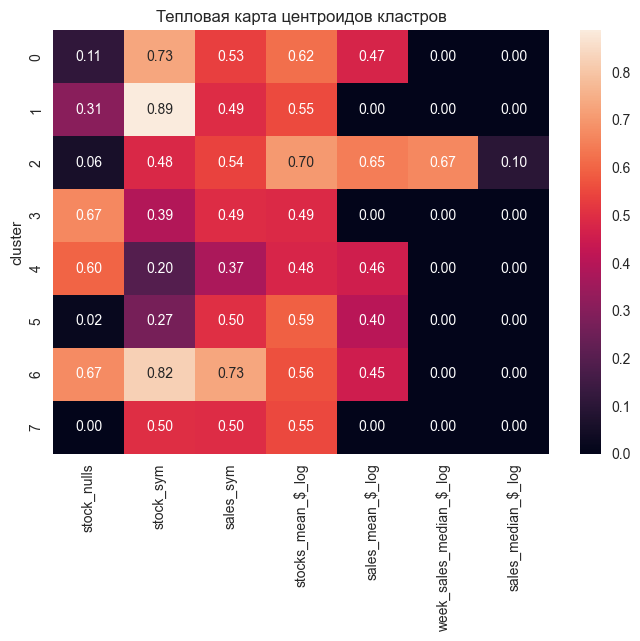

In [61]:
piv_nom_1 = piv_nom[ ['stock_nulls', 'stock_sym', 'sales_sym',
       'stocks_mean_$_log', 'sales_mean_$_log','week_sales_median_$_log','sales_median_$_log'] ]

scaler = MinMaxScaler()
piv_nom_1 = scaler.fit_transform(piv_nom_1)
piv_nom_1 = pd.DataFrame(piv_nom_1, columns=['stock_nulls', 'stock_sym', 'sales_sym',
       'stocks_mean_$_log', 'sales_mean_$_log','week_sales_median_$_log','sales_median_$_log'] )
piv_nom_1['cluster'] = labels

cluster_definition = piv_nom_1.groupby('cluster').mean()
fig = sns.heatmap(cluster_definition, annot=True, fmt='.2f')
fig.set_title('Тепловая карта центроидов кластров')

In [62]:
plot_cluster_profile(cluster_definition,8)

**Выберем вариант с t-SNE + KMeans**

Поясню почему.

Нам нужно разумное число кластеров. Соответвенно минимальное число, которое отображает сложность ассортимента.
При этом первой кластеризации только по методу агломеративной кластеризации мы получили 8 кластеров (4 кластера - очевидно слишком мало). Но коэфицент силуэта значительно ниже чем при варианте KMeans. Там мы получили 10 кластеров.

С предварительным снижением размерности же, мы получили четко 8 кластеров с высоким коэффицентом силуэта.

**Посмотрим, как можно назвать полученные кластеры**

* ***Кластер 2*** - это кластер, где есть регулярные продажи. Назовем его "Регулярные"
* ***Кластеры 1,3 и 7*** - это кластеры, вообще без продаж. Из них:
    * ***Кластер 3*** - кластер в котором за период почти нет остатков. Назовем "Без продаж. Редко на складе"
    * ***Кластер 1*** - кластер в котором остатки выросли, а продаж так и нет. "Без продаж. Плохие новинки"
    * ***Кластер 7*** - кластер в котором за постоянно есть остаток. Назовем "Висяки"
* ***Кластер 4*** - это кластер редкопродаваемых товаров, по которым падает запас. "Опасные. Распродано"
* ***Кластер 5*** - "Опасные. Динамика к распродаже"
* ***Кластер 6*** - это кластер редкопродаваемых товаров, по которым вырос запас и есть продажи. "Новинки с продажами"
* ***Кластер 0*** - это кластер редкопродаваемых товаров, по которым вырос запас и есть продажи. "Опасные. Большой остаток"

In [63]:
class_name_dict = {0:'Опасные. Большой остаток', 1: 'Без продаж. Плохие новинки', 2: 'Регулярные', 
                       3: 'Без продаж. Редкие остатки', 4: 'Опасные. Распродано', 5: 'Опасные. Динамика к распродаже', 
                       6: 'Новинки с продажами', 7: 'Висяки'}

**Построим дерево решений, чтобы уметь различать кластеры в новых данных**

Кластеры выглядят очень различными по составу. Поэтому попробуем простое дерево решений и если оно даст хорошую точность, то отлично. Внешне кажется, что дерево решений должно получится простым т.к. кластеры по параметрам выглядят очень различными. 

In [64]:
# Создаём матрицу наблюдений X и вектор правильных ответов y. piv_nom1
X = piv_nom_1.drop('cluster',axis=1) 
y = piv_nom_1['cluster'] 

In [65]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=42)

In [66]:
param_grid = {
    'max_depth': range(5, 10),
    'criterion': ['gini', 'entropy']
}

best_tree = model_selection.GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42),
    cv=5,
    param_grid=param_grid,
    scoring='accuracy'
)

best_tree.fit(X_train,y_train)
print('Лучшие параметры: ', best_tree.best_params_)
y_test_pred =  best_tree.predict(X_test)
print('Ассuracy на тестовых данных: ', metrics.accuracy_score(y_test, y_test_pred))

Лучшие параметры:  {'criterion': 'gini', 'max_depth': 9}
Ассuracy на тестовых данных:  0.9825


Запомним отдельно выбранную модель DecigionTree

In [67]:
best_tree = tree.DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=9)
best_tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=9, random_state=42)

Классификация происходит с высокой точностью. Метрика accuracy для нас вполне подходит, наши классы более менее равномерны.
Посмотрим теперь на результат классификации по всему набору данных

In [68]:
piv_nom_1['class'] = best_tree.predict(X)

Text(0.5, 1.0, 'Тепловая карта центроидов кластеров, поученных через DecisionTree')

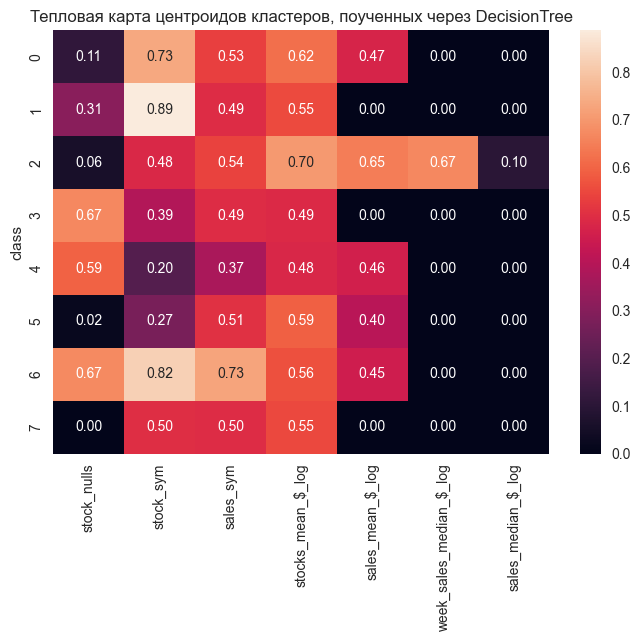

In [69]:
cluster_definition = piv_nom_1.drop('cluster', axis=1).groupby('class').mean()
fig = sns.heatmap(cluster_definition, annot=True, fmt='.2f')
fig.set_title('Тепловая карта центроидов кластеров, поученных через DecisionTree')

In [70]:
piv_nom['class'] = piv_nom_1['class']

In [71]:
#for i in range(8):
#
#    cluster = list(piv_nom[piv_nom['class']==i]['АРТИКУЛ'])
    #cluster = list(piv_nom[piv_nom['sales_median_$_log'] > 0]['АРТИКУЛ'])

#    fig, axes = plt.subplots(len(cluster)//6+2,6, figsize = [20,len(cluster)//6*2+3])
#    for i,art in enumerate(cluster):
#        if art in list(table.columns):
#            sns.lineplot(table[art].T, ax=axes[i//6][i%6])
#        if art in list(table2.columns):    
#            sns.lineplot(table2[art].T, ax=axes[i//6][i%6])
#        axes[i//6][i%6].set_xlabel(' ')
#        axes[i//6][i%6].set_ylabel(' ')
#        axes[i//6][i%6].set_title(art)
     
#plt.tight_layout()

Сериализуем нашу модель в файл, который будем использовать, как рабочий в продакшне.

In [72]:
import pickle

with open('stock_classifier.pkl', 'wb') as output:
    pickle.dump(best_tree, output)

## ДОПОЛНИТЕЛЬНЫЕ ИССЛЕДОВАНИЯ ДАННЫХ ДЛЯ ИСПОЛЬЗОВАНИЯ ПОЛУЧЕННОЙ МОДЕЛИ В ПРОДАКШНЕ

Перед тем как заниматься исследованиями в разрезе кластеров, присвоим кластерам имена:

In [73]:
class_name_dict = {0:'Опасные. Большой остаток', 1: 'Без продаж. Плохие новинки', 2: 'Регулярные', 
                       3: 'Без продаж. Редкие остатки', 4: 'Опасные. Распродано', 5: 'Опасные. Динамика к распродаже', 
                       6: 'Новинки с продажами', 7: 'Без продаж. Висяки'}

piv_nom['cluster_name'] = piv_nom['cluster'].apply(lambda x: class_name_dict[x])

### Уровень дефицита по кластерам

Теория управления товарным запасом говорит о том, что запас находится в каждый момент времени в каких-то зонах. Уловно, зона где его уже явно не хватает, или зона где его слишком много, а также зона оптимума. Иногда выделяют и другие зоны, часто эти зоны маркируют цветами (красная, зеленая и т.п.). Соответственно, рекомендации по заказу строятся исходя из показателей этих зон.

На этом этапе я хочу принять решения о том, как вычислять зону дефицита (т.е. товары с запасом менее этого уровня будут считаться в дефиците), но с оглядкой на кластеры.
Условно, мы ищем такой уровень товарного запаса, что статистически большой заказ ниже этого уровня мы выполнить не сможем. Однако при этом он не должен быть завышен.

Понятно, что наиболее критичен дефицит для товаров, которые мы назвали Регулярными по получившемуся в результате нашего моделирования делению. Поэтому начнем исследование с регулярных товаров.

Изначально рассмотрим такую гипотезу: Для товаров кластера "Регулярные" у нас условно "много" наблюдений продаж, т.к. туда входят товары исходя из анализа выше с ненулевыми медиванными продажами понедельно.

Т.е. если представить продажу по конкретному артикулу в день как случайную величину, которая с какой-то вероятностью $p$ равна нулю, а с вероятностью $(1-p)$ принимает значение некой второй случайной величины $\phi$, то, для $\phi$ у нас будет "довольно много" наблюдений. 

Тогда гипотеза такая: если распределение $\phi$ или нормально или логнормально, то мы сможем воспользоваться, например, методом 3х сигм, и получить эту границу, как как правую границу по этому методу.

Проверим для начала эту теорию на каком-нибудь самом популярном товаре.

In [74]:
#Выведем ТОП артикулов с минимальным показателем sales_nulls. 
#Эти артикулы очевидно будут артикулами регулярными и с самым большим числом наблюдений продаж
piv_nom.sort_values(by='sales_nulls', ascending=True)[['АРТИКУЛ', 'sales_nulls','cluster_name']].head(3)

АРТИКУЛ  sales_nulls cluster_name
218  1150051     0.051724   Регулярные
249  1106386     0.068966   Регулярные
255  1106395     0.120690   Регулярные

Посмотрим подробно на распределение продаж по ТОП1 артикулу

Text(0.5, 1.0, 'Распределение продаж ТОП1 по частоте продаж артикула')

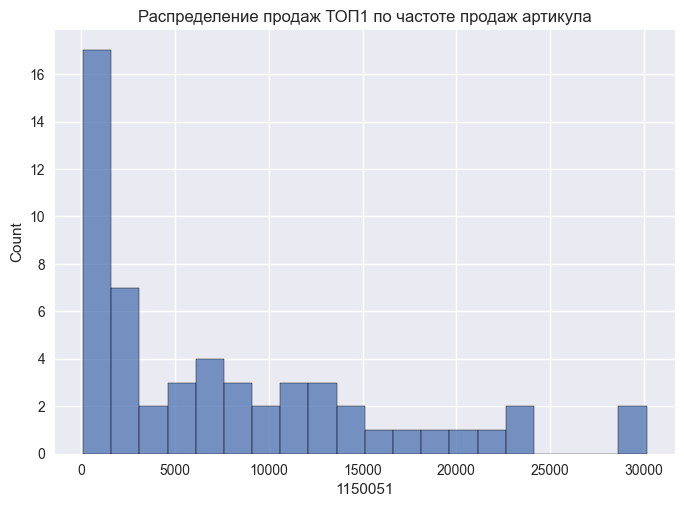

In [75]:
art = piv_nom.sort_values(by='sales_nulls', ascending=True)[['АРТИКУЛ', 'sales_nulls','cluster_name']].head(3)['АРТИКУЛ'].iloc[0]

reserch_table = table2[art].T
reserch_table = reserch_table[reserch_table > 0] #ВОзьмем только ненудевые наблюдения
fig = sns.histplot(reserch_table, bins=20)
fig.set_title('Распределение продаж ТОП1 по частоте продаж артикула')

Данное распределение очевидно не нормальное. Посмотим, что получится, если его логарифмировать.

Text(0.5, 1.0, 'Распределение лог-продаж ТОП1 по частоте продаж артикула')

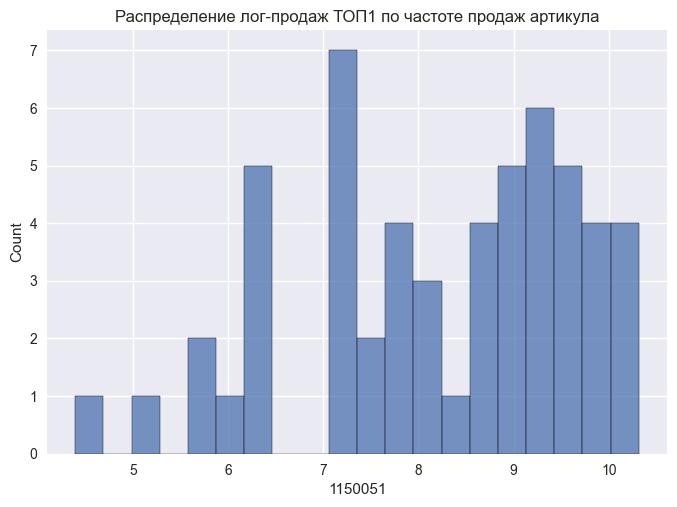

In [76]:
reserch_table = table2[art].T.apply(lambda x: 0 if (x+1)<=0 else np.log(x+1))
reserch_table = reserch_table[reserch_table > 0]
fig = sns.histplot(reserch_table, bins=20)
fig.set_title('Распределение лог-продаж ТОП1 по частоте продаж артикула')

Данное распределение чисто внешне тоже никак не выглядит, увы, нормальным. Давайте убедимся в этом проведя статистический тест. Нулевая гипоза - "данные распределены нормально". $\alpha$ пусть будет $= 0.05$ 

In [77]:
from scipy.stats import shapiro

shapiro(reserch_table).pvalue

0.01619495078921318

Получили $p-value < alpha$. Отвегаем нулевую гипотезу. Данные не распределны нормально. Если это так для артикула, где у нас самое большое количество наблюдний, то на мой взгляд, другие проверять и смысла нет.

Тогда, самое простое, что можно придумать - поиграться с квартилями. Условно, q75 - в данном случае будет значит, что 75% наблюдений продаж пападают ниже этого уровня. Давайте посмотрим на графики boxplot для всех "Регулярных" артикулов, чтобы получить представление в совокупности.

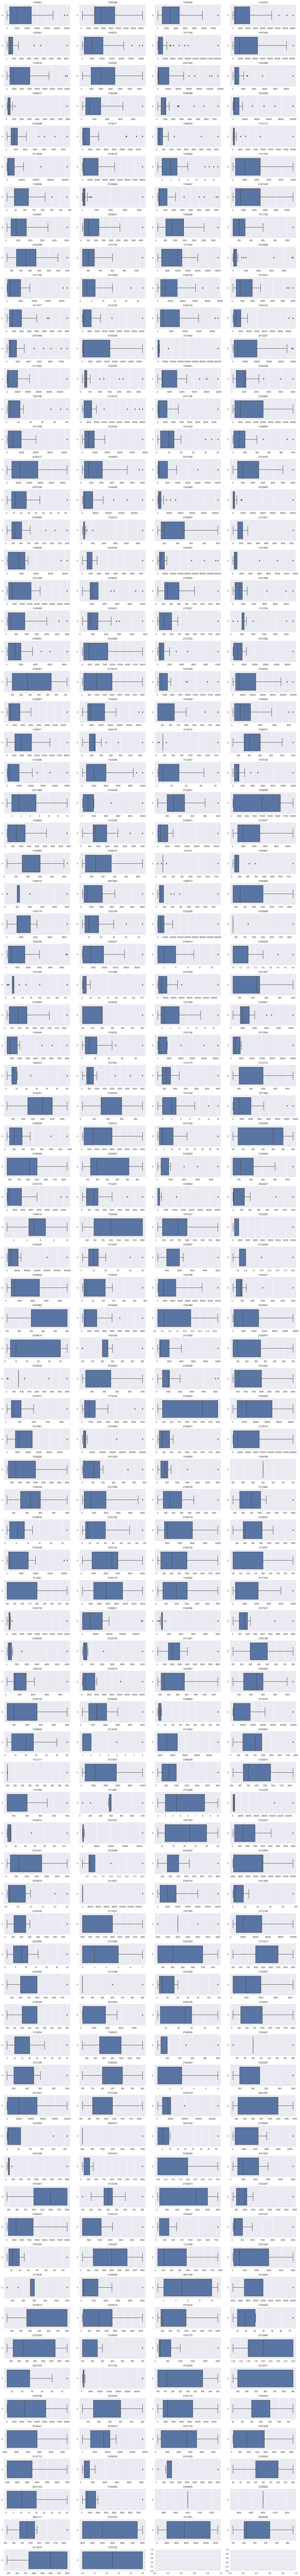

In [78]:
art_list = piv_nom[piv_nom['cluster_name']=='Регулярные'].sort_values(by='sales_nulls', 
                                                                      ascending=True)[['АРТИКУЛ', 'sales_nulls']]['АРТИКУЛ'].values
art_list = list(art_list)


fig, axes = plt.subplots(len(art_list)//4+1,4, figsize = [20,len(art_list)//4*2+3])
for i,art in enumerate(art_list):
    reserch_table = table2[art].T
    reserch_table = reserch_table[reserch_table>0] #Рассматриваем только ненулевые продажи
    sns.boxplot(reserch_table, ax=axes[i//4][i%4], orient='h')
    axes[i//4][i%4].set_title(art)

plt.tight_layout()

Что мы видим? Часть товаров имеют явные выбросы в продажах, тогда как другие расположены очень компактно. У меня отсюда рождается такая эвристика:

Если у нас есть выбросы, то за уровень дефицита будем брать правую границу по методу Тьюки (т.е. конец правого "уса"), А если выбросов нет, то просто максимальный уровень продаж, чтобы уровень дефицита не поднимался выше уровня факта каких-то наблюдаемых продаж.

Эту эвристику мы и будем использовать для "Реглярных" товаров в части продакшна.

In [79]:
class_name_dict = {0:'Опасные. Большой остаток', 1: 'Без продаж. Плохие новинки', 2: 'Регулярные', 
                       3: 'Без продаж. Редкие остатки', 4: 'Опасные. Распродано', 5: 'Опасные. Динамика к распродаже', 
                       6: 'Новинки с продажами', 7: 'Без продаж. Висяки'}

Теперь определимся с уровнем дефицита по другим кластерам.
Очевидно, что для 3х кластеров "Без продаж" это значение должно быть равно нулю.

С 3мя "Опасными" кластерами и кластером "Новинки с продажами" все сложнее. В этих кластерах мало наблюдений продаж.

По сути все "Опасные" товары условно "плохие" для ассортимента. И тут, скорее нужно управленческое решение заказчика: будем мы по ним считать дефицит или нет. Я бы не считал (т.к. данный проект является реализацией моих идей, и заказчик я, то на этом и остановимся)

Из этих 4х кластеров, потенциально "хорошие" товары, которые стоит заказывать находятся в первую очередь в "Новинках с продажами". Теоретически для них может быть применим тот же подход, что и для "Регулярных". Что ж, давайте взглянем на диаграммы с усами для этих товаров:

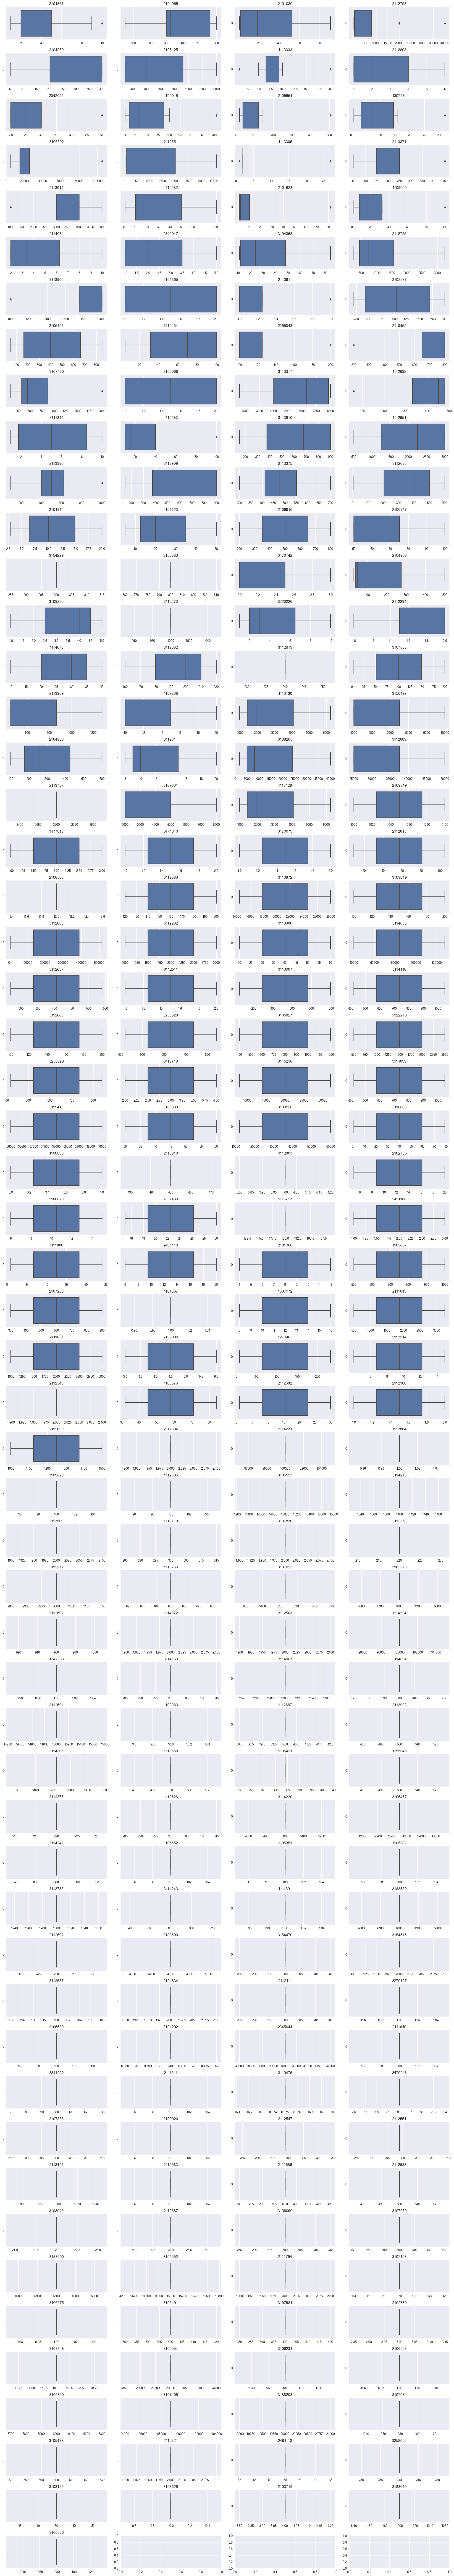

In [80]:
art_list = piv_nom[piv_nom['cluster_name']=='Новинки с продажами'].sort_values(by='sales_nulls', 
                                                                      ascending=True)[['АРТИКУЛ', 'sales_nulls']]['АРТИКУЛ'].values
art_list = list(art_list)


fig, axes = plt.subplots(len(art_list)//4+1,4, figsize = [20,len(art_list)//4*2+3])
for i,art in enumerate(art_list):
    reserch_table = table2[art].T
    reserch_table = reserch_table[reserch_table>0] #Рассматриваем только ненулевые продажи
    sns.boxplot(reserch_table, ax=axes[i//4][i%4], orient='h')
    axes[i//4][i%4].set_title(art)

plt.tight_layout()

Как и ожидалось, товаров с выбросами намного меньше, а также появилось много товаров по сути с одной продажей. Остановимся на логике аналогичной "Регулярным" все-таки.